In [103]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from haversine import haversine, Unit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from meteostat import Point, Hourly
from datetime import datetime


In [104]:
bike_data = pd.read_csv('data/202301-bluebikes-tripdata.csv')

In [105]:
bike_data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,250,2023-01-01 00:02:54.0800,2023-01-01 00:07:04.4100,36,Copley Square - Dartmouth St at Boylston St,42.349928,-71.077392,21,Prudential Center - 101 Huntington Ave,42.346520,-71.080658,4213,Subscriber,02115
1,489,2023-01-01 00:10:33.3100,2023-01-01 00:18:42.3690,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,-71.083370,3153,Customer,NaN
2,461,2023-01-01 00:10:49.9130,2023-01-01 00:18:31.1280,372,Boylston St at Exeter St,42.349589,-71.079468,404,Mass Ave T Station,42.341356,-71.083370,3431,Customer,02186
3,1065,2023-01-01 00:13:58.0640,2023-01-01 00:31:43.5090,58,Mugar Way at Beacon St,42.355536,-71.072869,345,Park Plaza at Charles St S.,42.351828,-71.067811,4398,Customer,NaN
4,601,2023-01-01 00:14:02.6130,2023-01-01 00:24:03.8950,50,Boylston St at Berkeley St,42.351142,-71.073292,374,Tremont St at Hamilton Pl,42.356683,-71.061666,7964,Subscriber,02138


In [106]:
bike_data.shape

(140340, 14)

In [107]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140340 entries, 0 to 140339
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tripduration             140340 non-null  int64  
 1   starttime                140340 non-null  object 
 2   stoptime                 140340 non-null  object 
 3   start station id         140340 non-null  int64  
 4   start station name       140340 non-null  object 
 5   start station latitude   140340 non-null  float64
 6   start station longitude  140340 non-null  float64
 7   end station id           140340 non-null  int64  
 8   end station name         140340 non-null  object 
 9   end station latitude     140340 non-null  float64
 10  end station longitude    140340 non-null  float64
 11  bikeid                   140340 non-null  int64  
 12  usertype                 140340 non-null  object 
 13  postal code              131990 non-null  object 
dtypes: f

In [108]:
bike_data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid
count,1.403400e+05,140340.000000,140340.000000,140340.000000,140340.00000,140340.000000,140340.000000,140340.000000
mean,1.260807e+03,206.073571,42.359247,-71.091262,204.45600,42.359176,-71.090774,5785.957076
std,1.935545e+04,174.294858,0.018060,0.026352,174.21936,0.017997,0.026327,2001.094702
min,6.100000e+01,3.000000,42.255600,-71.247759,1.00000,42.255600,-71.247759,2007.000000
25%,3.860000e+02,67.000000,42.348545,-71.107287,67.00000,42.348706,-71.106500,4063.000000
50%,6.170000e+02,142.000000,42.359825,-71.093198,139.00000,42.359573,-71.091567,5964.000000
75%,1.001000e+03,365.000000,42.368952,-71.073292,364.00000,42.368605,-71.072869,7704.000000
max,2.296250e+06,591.000000,42.529900,-70.886930,591.00000,42.529900,-70.886930,8708.000000


# Adding weather data


temp: Temperature in °C. You can use this for temperature categorization (cold, hot, etc.).

dwpt (Dew Point): Shows the temperature at which air reaches saturation. It can help assess humidity.

rhum (Relative Humidity): Indicates moisture in the air. High humidity may correlate with foggy or uncomfortable conditions.

prcp (Precipitation): The amount of rain in mm. This is a critical feature, as rain could reduce bike usage.

snow: Amount of snowfall. If available, this feature can indicate bad weather that impacts mobility.

wdir (Wind Direction): Could help identify patterns where high winds affect bike riding.

wspd (Wind Speed): Wind speed in km/h. Windy conditions might also explain anomalies, such as shorter or fewer trips.

wpgt (Wind Gust): This represents wind gust speed in km/h, indicating the maximum short burst of wind speed during the hour. 

pres (Pressure): Atmospheric pressure, useful for assessing weather patterns (e.g., high pressure = clear skies).

coco (Weather Condition Code): Encodes the general weather condition (clear, cloudy, rain, snow, etc.).

tsun (Sunshine): Amount of sunshine (though it seems missing here).

In [109]:
boston = Point(42.3601, -71.0589)  # Latitude and Longitude for Boston

In [110]:
start = datetime(2023, 1, 1)
end = datetime(2023, 1, 31)

weather_data_hourly = Hourly(boston, start, end)
weather_data_hourly = weather_data_hourly.fetch()

# Show the first few rows of the fetched data
print(weather_data_hourly.head())

                     temp  dwpt   rhum  prcp  snow   wdir  wspd  wpgt    pres  \
time                                                                            
2023-01-01 00:00:00  11.1  11.1  100.0   1.2   NaN  180.0  13.0   NaN  1010.4   
2023-01-01 01:00:00  11.1  11.1  100.0   0.3   NaN  190.0  11.2   NaN  1008.9   
2023-01-01 02:00:00  11.7  11.7  100.0   0.5   NaN  210.0  13.0   NaN  1008.2   
2023-01-01 03:00:00  11.1  11.1  100.0   1.8   NaN  190.0  11.2   NaN  1006.2   
2023-01-01 04:00:00  12.2  12.2  100.0   2.3   NaN  220.0  16.6   NaN  1005.3   

                     tsun  coco  
time                             
2023-01-01 00:00:00   NaN   7.0  
2023-01-01 01:00:00   NaN   7.0  
2023-01-01 02:00:00   NaN   7.0  
2023-01-01 03:00:00   NaN   7.0  
2023-01-01 04:00:00   NaN   7.0  


In [111]:
weather_data_hourly = weather_data_hourly.reset_index()

In [112]:
# Ensure both are in datetime format
bike_data['starttime'] = pd.to_datetime(bike_data['starttime'])
weather_data_hourly['time'] = pd.to_datetime(weather_data_hourly['time'])

bike_weather_data = pd.merge_asof(bike_data, weather_data_hourly, left_on='starttime', right_on='time', direction='nearest')

print(bike_weather_data.head())


   tripduration               starttime                  stoptime  \
0           250 2023-01-01 00:02:54.080  2023-01-01 00:07:04.4100   
1           489 2023-01-01 00:10:33.310  2023-01-01 00:18:42.3690   
2           461 2023-01-01 00:10:49.913  2023-01-01 00:18:31.1280   
3          1065 2023-01-01 00:13:58.064  2023-01-01 00:31:43.5090   
4           601 2023-01-01 00:14:02.613  2023-01-01 00:24:03.8950   

   start station id                           start station name  \
0                36  Copley Square - Dartmouth St at Boylston St   
1               372                     Boylston St at Exeter St   
2               372                     Boylston St at Exeter St   
3                58                       Mugar Way at Beacon St   
4                50                   Boylston St at Berkeley St   

   start station latitude  start station longitude  end station id  \
0               42.349928               -71.077392              21   
1               42.349589           

# Feature Engineering

In [113]:
# Check for NaN values 
print(bike_weather_data.isnull().sum())
print(len(bike_weather_data))

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  0
end station name                0
end station latitude            0
end station longitude           0
bikeid                          0
usertype                        0
postal code                  8350
time                            0
temp                            0
dwpt                            0
rhum                            0
prcp                            0
snow                       140340
wdir                            0
wspd                            0
wpgt                       140340
pres                            0
tsun                       140340
coco                            0
dtype: int64
140340


In [114]:
bike_weather_data = bike_weather_data.drop(columns=['snow', 'wpgt', 'tsun'])
print(bike_weather_data.isnull().sum())

tripduration                  0
starttime                     0
stoptime                      0
start station id              0
start station name            0
start station latitude        0
start station longitude       0
end station id                0
end station name              0
end station latitude          0
end station longitude         0
bikeid                        0
usertype                      0
postal code                8350
time                          0
temp                          0
dwpt                          0
rhum                          0
prcp                          0
wdir                          0
wspd                          0
pres                          0
coco                          0
dtype: int64


Code	Weather Condition

1	Clear

2	Fair

3	Cloudy

4	Overcast

5	Fog

6	Freezing Fog

7	Light Rain

8	Rain

9	Heavy Rain

10	Freezing Rain

11	Heavy Freezing Rain

12	Sleet

13	Heavy Sleet

14	Light Snowfall

15	Snowfall

16	Heavy Snowfall

17	Rain Shower

18	Heavy Rain Shower

19	Sleet Shower

20	Heavy Sleet Shower

21	Snow Shower

22	Heavy Snow Shower

23	Lightning

24	Hail

25	Thunderstorm

26	Heavy Thunderstorm

27	Storm

In [115]:
bike_weather_data['coco']

0         7.0
1         7.0
2         7.0
3         7.0
4         7.0
         ... 
140335    3.0
140336    3.0
140337    3.0
140338    3.0
140339    3.0
Name: coco, Length: 140340, dtype: float64

## Create duration types (short, average, long, extra long)

In [8]:
bike_data['tripduration_type'] = np.where(bike_data['tripduration'] < 3600, "short_trip", np.where(
    (bike_data['tripduration'] > 3600) & (bike_data['tripduration'] < 3600 * 24), "average_trip", np.where(
    (bike_data['tripduration'] > 3600 * 24) & (bike_data['tripduration'] < 3600 * 24 * 30), "long_trip",
        "extra_long_trip")))

## Calculate Distance (in kilometers) 

In [116]:
def calculate_distances_vectorized(df):
    start_coords = list(zip(df['start station latitude'], df['start station longitude']))
    end_coords = list(zip(df['end station latitude'], df['end station longitude']))
    return np.array([haversine(start, end, unit=Unit.KILOMETERS) for start, end in zip(start_coords, end_coords)])


In [117]:
bike_weather_data['distance'] = calculate_distances_vectorized(bike_weather_data)

## Extract the hour/day/month as features

In [120]:
bike_weather_data['start_hour'] = bike_weather_data['starttime'].dt.hour
bike_weather_data['start_dayofweek'] = bike_weather_data['starttime'].dt.dayofweek
bike_weather_data['start_month'] = bike_weather_data['starttime'].dt.month

bike_weather_data['end_hour'] = pd.to_datetime(bike_weather_data['stoptime']).dt.hour
bike_weather_data['end_dayofweek'] = pd.to_datetime(bike_weather_data['stoptime']).dt.dayofweek
bike_weather_data['end_month'] = pd.to_datetime(bike_weather_data['stoptime']).dt.month

## Encode the 'member_casual', 'rideable_type', 'duration' column

In [122]:
label_encoder = LabelEncoder()
bike_weather_data['user_type_encoded'] = label_encoder.fit_transform(bike_weather_data['usertype'])
# bike_data['rideable_type_encoded'] = label_encoder.fit_transform(bike_data['rideable_type'])
# bike_data['duration_type_encoded'] = label_encoder.fit_transform(bike_data['tripduration_type'])

## Select relevant features

In [142]:
# Select relevant features for anomaly detection
# features = ['duration_type_encoded', 'distance', 'user_type_encoded']
# features = ['duration_type_encoded']
# features = ['tripduration', 'distance', 'user_type_encoded']
features = ['tripduration', 'distance', 'user_type_encoded', 
                    'temp', 'wspd', 'prcp', 'coco', 
                    'start_hour', 'start_dayofweek', 'start_month', 
                    'end_hour', 'end_dayofweek', 'end_month']
X = bike_weather_data[features]


In [177]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X)

bike_weather_data['PCA1'] = X_pca[:, 0]
bike_weather_data['PCA2'] = X_pca[:, 1]
bike_weather_data['PCA3'] = X_pca[:, 2]
bike_weather_data['PCA4'] = X_pca[:, 3]
bike_weather_data['PCA5'] = X_pca[:, 4]
bike_weather_data['PCA6'] = X_pca[:, 5]


In [172]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

bike_data['PCA_only'] = X_pca


# Data Analysis

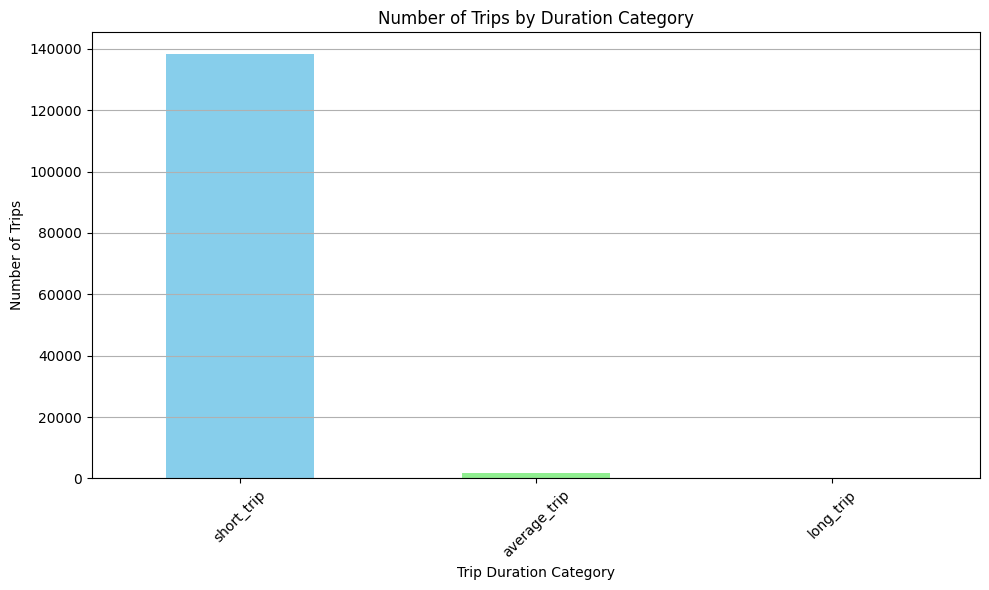

In [14]:
# Count the number of trips in each category
trip_counts = bike_data['tripduration_type'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
trip_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon', 'gold'])
plt.title('Number of Trips by Duration Category')
plt.xlabel('Trip Duration Category')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
trip_counts

tripduration_type
short_trip      138477
average_trip      1735
long_trip          128
Name: count, dtype: int64

In [29]:
contamination = trip_counts['long_trip'] / bike_data.shape[0]

In [30]:
contamination

np.float64(0.0009120706854781245)

# Train Isolation Forest

In [184]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.005, n_estimators=500, max_samples=0.6, max_features=0.9) 

# Fit the model to the data
# bike_weather_data['anomaly'] = iso_forest.fit_predict(X_scaled)
bike_weather_data['anomaly'] = iso_forest.fit_predict(bike_weather_data[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6']])
# bike_data['anomaly'] = iso_forest.fit_predict(bike_data[['PCA_only']])
# bike_weather_data['anomaly'] = iso_forest.fit_predict(X)



# Plot the Anomalies

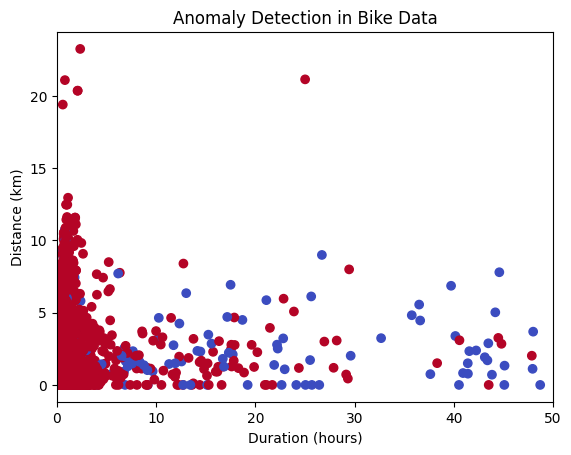

    tripduration               starttime                  stoptime  \
0            250 2023-01-01 00:02:54.080  2023-01-01 00:07:04.4100   
7           1693 2023-01-01 00:18:49.451  2023-01-01 00:47:03.1900   
8           1689 2023-01-01 00:19:33.867  2023-01-01 00:47:43.5990   
9           1615 2023-01-01 00:19:45.343  2023-01-01 00:46:40.3830   
13          1398 2023-01-01 00:24:25.968  2023-01-01 00:47:44.3140   

    start station id                                 start station name  \
0                 36        Copley Square - Dartmouth St at Boylston St   
7                 50                         Boylston St at Berkeley St   
8                 50                         Boylston St at Berkeley St   
9                 50                         Boylston St at Berkeley St   
13                75  Lafayette Square at Mass Ave / Main St / Colum...   

    start station latitude  start station longitude  end station id  \
0                42.349928               -71.077392      

In [185]:
# Visualize the anomalies (1 = normal, -1 = anomaly)
plt.scatter(bike_weather_data['tripduration'] / 3600, bike_weather_data['distance'], c=bike_weather_data['anomaly'], cmap='coolwarm')

plt.xlim(0, 50)

plt.xlabel('Duration (hours)')
plt.ylabel('Distance (km)')
plt.title('Anomaly Detection in Bike Data')
plt.show()

# Print detected anomalies
anomalies = bike_weather_data[bike_weather_data['anomaly'] == -1]
print(anomalies.head())

In [187]:
anomalies.shape

(702, 38)

In [188]:
print(anomalies['coco'].mean())
print(bike_weather_data[bike_weather_data['anomaly'] == 1]['coco'].mean())

8.690883190883191
4.0543261862816715


In [182]:
anomalies['start_dayofweek']

7         6
8         6
9         6
13        6
30        6
         ..
134359    1
134365    1
134374    1
134376    1
134389    1
Name: start_dayofweek, Length: 702, dtype: int32